<a href="https://colab.research.google.com/github/Pimateos/Deep-Learning/blob/master/Pr%C3%A1cticaFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parte 1: Cuestionario (2.5 puntos)

### 1.1 *(0.5 puntos)* Explicar por qué es preferible hacer np.dot(X, Y), donde X e Y son arrays bidimensionales, que ejecutar un triple bucle con el algoritmo básico de la multiplicación de matrices.

Porque numpy calcula en paralelo las matrices en lugar del metodo clasico que se itera.

### 1.2 *(0.5 puntos)* Explicar qué ventajas nos aporta utilizar un grafo de computación a la hora de entrenar redes neuronales.

Sabemos el orden que tienen las operaciones y si son compatibles.

Mas velocidad de ejecución.

Nos permite poder establecer el punto desde el cual queremos computar. Ademas de establecer paralelismos. Esto nos ayuda a ejecutar en entornos distribuidos y/o GPUs.

Los frameworks modernos tienen operaciones embebidas en los nodos de los grafos, por ejemplo, el backward propagation.  Esto lo hacen automaticamente y es muy importante en redes muy grandes(autodiferenciación)

### 1.3 *(0.5 puntos)* Hemos visto cómo con TensorFlow es posible añadir una operación de optimización (como *tf.train.GradientDescentOptimizer*) y aplicar con ésta la minimización de la función de pérdida. Explicar cómo afecta esto al grafo de computación y cuál es su relación con el entrenamiento de una red neuronal.

Gradient Descent Optimizer nos permite calcular el array cuando tenemos variables variables minimizando el error de las mismas al valor que establezcamos, pero computandola optimizando el calculo de matrices.

### 1.4 *(0.5 puntos)* ¿Qué diferencias hay entre grafos estáticos y grafos dinámicos?




Los grafos estáticos se calculan antes de ejecutar el código. Mientras que los grafos dinámicos se calculan mientras se estan ejecutando. Pytorch los calcula dinámicamente. Mientras que Tensorflow estáticamente en versiones antiguas. A partir de Tensorflow 2.0 se calculan por defecto dinámicamente y se puede cambiar a forma estática.

Los grafos dinamicos son buenos para experimentación. Sin embargo, para producción son mejores los estáticos.

### 1.5 *(0.5 puntos)* Algunas ops en redes neuronales tienen un comportamiento diferente durante *training time* (cuando entrenamos la red) que durante *inference time* (cuando utilizamos la red ya entrenada). Da un ejemplo de una operación usada en redes neuronales de este tipo y explicar la diferencia en ejecución. ¿Qué consecuencias tiene esto en relación al grafo de computación?

Dropout se utiliza para prevenir el overfitting. No teniendo en cuenta aleatoriamente una neurona. Consiguiendo con su introduccion en el entrenamiento, modelos mas robustos.

En la parte de inferencia no tendria sentido utilizar esta técnica, ya que, ya tenemos entrenada la red y no tendria sentido meter un componente aleatorio en la predicción también. Porque la salida nos daria una predicción aleatoria.


# Parte 2: Laboratorio (7.5 puntos)

---



En este laboratorio, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el clásico dataset de MNIST. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [0]:
import cv2
import os
import numpy as np 
import keras
import matplotlib.pyplot as plt
import glob


# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets

# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

In [0]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [0]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)


In [0]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [29]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


## Entregable

Utilizando Convolutional Neural Networks con TensorFlow (ya sea tf.keras, TensorFlow Eager, o TensorFlow tradicional), entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de **88%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

El entregable (en formato .ipynb, aunque puede apoyarse con un archivo pdf) tiene que contener los siguientes elementos:

**1 (1.5 puntos): Implementación con una red neuronal clásica**. Implementar primero un modelo feed-forward clásico, sin convoluciones. Mostrar código y  resultados de entrenamiento y accuracy en el test set.



In [30]:
print(X.shape)
print(X_t.shape)

(18992, 64, 64, 3)
(890, 64, 64, 3)


In [0]:
def plot_history(history):
    
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [0]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import RMSprop
from keras import backend as K


In [0]:
batch_size = 32
num_classes = 18
epochs = 20



In [34]:
# the data, split between train and test sets
img_rows=64
img_cols=64
if K.image_data_format() == 'channels_first':
    x_train = X.reshape(X.shape[0], 1, img_rows, img_cols)
    x_test = X_t.reshape(X_t.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = X.reshape(X.shape[0], img_rows, img_cols,3)
    x_test = X_t.reshape(X_t.shape[0], img_rows, img_cols,3)
    input_shape = (img_rows, img_cols,3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train= y
y_test=y_t
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train shape: (18992, 64, 64, 3)
18992 train samples
890 test samples


In [35]:
print(64*64*3)
print(input_shape)
print(x_test.shape)

12288
(64, 64, 3)
(890, 64, 64, 3)


In [36]:
model = Sequential()
model.add(Dense(3, activation='relu', input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64, 64, 3)         12        
_________________________________________________________________
dropout_3 (Dropout)          (None, 64, 64, 3)         0         
_________________________________________________________________
dense_5 (Dense)              (None, 64, 64, 512)       2048      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64, 64, 512)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2097152)           0         
_________________________________________________________________
dense_6 (Dense)              (None, 18)                37748754  
Total params: 37,750,814
Trainable params: 37,750,814
Non-trainable params: 0
________________________________________________________________

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),shuffle=True)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_history(history)

**2 (4.5 puntos): Implementación con CNNs**. Implementar una arquitectura CNN que consiga un 88% de accuracy en el test set. Mostrar código y resultados de entrenamiento y accuracy en el test set. Explicar brevemente la arquitectura utilizada y las pruebas realizadas.



# Implementacion con CNN

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from timeit import default_timer as timer
from keras.preprocessing import image
import numpy as np
import os
image_height = 64
image_width = 64

In [39]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [45]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 18
epochs = 20
#Se realiza el reshape y se normaliza para poder entrenar la red neuronal
img_rows=64
img_cols=64
if K.image_data_format() == 'channels_first':
    x_train = X.reshape(X.shape[0], 3, img_rows, img_cols)
    x_test = X_t.reshape(X_t.shape[0],3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = X.reshape(X.shape[0], img_rows, img_cols,3)
    x_test = X_t.reshape(X_t.shape[0], img_rows, img_cols,3)
    input_shape = (img_rows, img_cols,3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train= y
y_test=y_t
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Se convierte las clases en matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)










x_train shape: (18992, 64, 64, 3)
18992 train samples
890 test samples


In [41]:
x_train.shape

(18992, 64, 64, 3)

In [18]:
x_test.shape

(890, 64, 64, 3)

In [0]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import os
import sys
import tarfile
import numpy as np
img_width, img_height = 64, 64
#Se establece el input_shape de la red neuronal con los channels y las dimensiones de las imagenes 64 y 64 (altura y anchura)
if K.image_data_format() == 'channels_first':
    input_shape = (img_width, img_height,3)
else:
    input_shape = (3,img_width, img_height)
#Se crea la red neuronal convolucional con 3 capas convolucionales y 3 capas densas. Se añade dropout del 50% para que no se sobreentrene y como es tenemos 18 clases
#se añade una capa final densa con el numero de clases 18 y con funcion de activacion softmax
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(64,64,3)))
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(18))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Train on 18992 samples, validate on 890 samples
Epoch 1/100
18992/18992 [==============================] - 20s 1ms/step - loss: 2.7046 - acc: 0.1476 - val_loss: 2.5055 - val_acc: 0.2011
Epoch 2/100
18992/18992 [==============================] - 16s 837us/step - loss: 2.2276 - acc: 0.3039 - val_loss: 1.9965 - val_acc: 0.4427
Epoch 3/100
18992/18992 [==============================] - 16s 836us/step - loss: 1.8307 - acc: 0.4321 - val_loss: 1.4656 - val_acc: 0.5674
Epoch 4/100
18992/18992 [==============================] - 16s 835us/step - loss: 1.5457 - acc: 0.5168 - val_loss: 1.1508 - val_acc: 0.6449
Epoch 5/100
18992/18992 [==============================] - 16s 835us/step - loss: 1.3288 - acc: 0.5815 - val_loss: 1.0169 - val_acc: 0.7022
Epoch 6/100
18992/18992 [==============================] - 16s 836us/step - loss: 1.1569 - acc: 0.6314 - val_loss: 0.8301 - val_acc: 0.7472
Epoch 7/100
18992/18992 [==============================] - 16s 835us/step - loss: 1.0343 - acc: 0.6667 - val_loss:

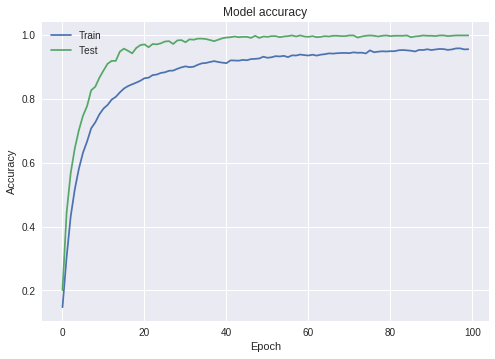

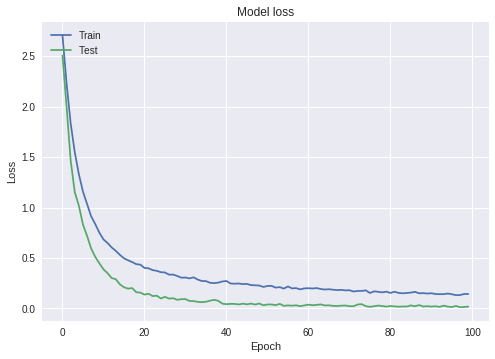

In [48]:
#Se entrena
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=100,
                    verbose=1,
                    validation_data=(x_test, y_test),shuffle=True)
#Se calcula como se comporta
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
#Se muestra graficamente
plot_history(history)

Probamos otra arquitectura de red con 4 capas convolucionales y distintos numeros de neuronas aumentando de 64 a 128 a 256 y finalmente disminuyendo y compleentando con 3 capas densas. La final con 18 neuronas, numero de clases a clasificar.

In [0]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import os
import sys
import tarfile
import numpy as np
img_width, img_height = 64, 64
if K.image_data_format() == 'channels_first':
    input_shape = ( 3,img_width, img_height)
else:
    input_shape = (3,img_width, img_height)

model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(64,64,3)))
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(18))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=100,
                    verbose=1,
                    validation_data=(x_test, y_test),shuffle=True)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_history(history)

Train on 18992 samples, validate on 890 samples
Epoch 1/100
18992/18992 [==============================] - 78s 4ms/step - loss: 2.6879 - acc: 0.1525 - val_loss: 2.5695 - val_acc: 0.1798
Epoch 2/100
18992/18992 [==============================] - 69s 4ms/step - loss: 2.3619 - acc: 0.2592 - val_loss: 2.2548 - val_acc: 0.3056
Epoch 3/100
18992/18992 [==============================] - 69s 4ms/step - loss: 2.1007 - acc: 0.3416 - val_loss: 1.9698 - val_acc: 0.3966
Epoch 4/100
18992/18992 [==============================] - 69s 4ms/step - loss: 1.8610 - acc: 0.4205 - val_loss: 1.6699 - val_acc: 0.4742
Epoch 5/100
18992/18992 [==============================] - 69s 4ms/step - loss: 1.6644 - acc: 0.4812 - val_loss: 1.4651 - val_acc: 0.5360
Epoch 6/100
18992/18992 [==============================] - 69s 4ms/step - loss: 1.4888 - acc: 0.5312 - val_loss: 1.2606 - val_acc: 0.5989
Epoch 7/100
18992/18992 [==============================] - 69s 4ms/step - loss: 1.3148 - acc: 0.5852 - val_loss: 1.0080 - va

**3 (1 punto): Comparación GPU/CPU**. Comparar el tiempo de entrenamiento de tu modelo por epoch utilizando GPUs y CPUs. Explicar por qué el uso de una aceleradora como una GPU acelera el entrenamiento de la red neuronal.

In [0]:
with tf.device('/gpu:0'):
  start_gpu = time.time()
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.fit(x_train, y_train, batch_size=10, nb_epoch=10, verbose=1, validation_data=(x_test, y_test))
  loss, acc = model.evaluate(x_test, y_test, verbose=0)
  print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))
  print ("Compilation Time : ", time.time() - start_gpu)

In [0]:
with tf.device('/cpu:0'):
  start_cpu = time.time()
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.fit(x_train, y_train, batch_size=10, nb_epoch=10, verbose=1, validation_data=(x_test, y_test))
  loss, acc = model.evaluate(x_test, y_test, verbose=0)
  print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))
  print ("Compilation Time : ", time.time() - start_cpu)



*texto en cursiva*

**4 (0.5 puntos): Utilización de tf.data**. Si no se ha entrenado el modelo en el paso 2 con tf.data, repetir la ingesta de datos (incluyendo el preprocesamiento de imágenes) para el modelo utilizando tf.data.

In [0]:
# create the training datasets
dx_train = tf.data.Dataset.from_tensor_slices(x_train)
# apply a one-hot transformation to each label for use in the neural network
dy_train = tf.data.Dataset.from_tensor_slices(y_train).map(lambda z: tf.one_hot(z, 10))
# zip the x and y training data together and shuffle, batch etc.
train_dataset = tf.data.Dataset.zip((dx_train, dy_train)).shuffle(500).repeat().batch(30)

In [0]:
# do the same operations for the validation set
dx_valid = tf.data.Dataset.from_tensor_slices(x_test)
dy_valid = tf.data.Dataset.from_tensor_slices(y_test).map(lambda z: tf.one_hot(z, 10))
valid_dataset = tf.data.Dataset.zip((dx_valid, dy_valid)).shuffle(500).repeat().batch(30)

In [0]:
# create general iterator
iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
next_element = iterator.get_next()

In [0]:
# make datasets that we can initialize separately, but using the same structure via the common iterator
training_init_op = iterator.make_initializer(train_dataset)
validation_init_op = iterator.make_initializer(valid_dataset)

In [0]:
def nn_model(in_data):
    bn = tf.layers.batch_normalization(in_data)
    fc1 = tf.layers.dense(bn, 50)
    fc2 = tf.layers.dense(fc1, 50)
    fc2 = tf.layers.dropout(fc2)
    fc3 = tf.layers.dense(fc2, 10)
    return fc3

In [0]:
# create the neural network model
logits = nn_model(next_element[0])

In [0]:
# add the optimizer and loss
loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(labels=next_element[1], logits=logits))
optimizer = tf.train.AdamOptimizer().minimize(loss)
# get accuracy
prediction = tf.argmax(logits, 1)
equality = tf.equal(prediction, tf.argmax(next_element[1], 1))
accuracy = tf.reduce_mean(tf.cast(equality, tf.float32))
init_op = tf.global_variables_initializer()

In [0]:
# run the training
epochs = 600
with tf.Session() as sess:
    sess.run(init_op)
    sess.run(training_init_op)
    for i in range(epochs):
        l, _, acc = sess.run([loss, optimizer, accuracy])
        if i % 50 == 0:
            print("Epoch: {}, loss: {:.3f}, training accuracy: {:.2f}%".format(i, l, acc * 100))
    # now setup the validation run
    valid_iters = 100
    # re-initialize the iterator, but this time with validation data
    sess.run(validation_init_op)
    avg_acc = 0
    for i in range(valid_iters):
        acc = sess.run([accuracy])
        avg_acc += acc[0]
    print("Average validation set accuracy over {} iterations is {:.2f}%".format(valid_iters,                                                                              (avg_acc / valid_iters) * 100))



**5 [optativo] (1 punto extra). Implementar el modelo en TensorFlow Eager o TF de bajo nivel, sin usar tf.keras.** El bucle de entrenamiento batch a batch también tiene que hacerse utilizando operaciones de bajo nivel. En resumen, no vale utilizar capas de Keras como convoluciones o Dense ni funciones como .fit(), hay que implementarlas. Podéis programar el modelo sin embargo utilizando Keras subclassing (tf.keras.Model).




**6 [optativo] (0.5 puntos extra). Utilizar data augmentation.** Utilizar la técnica de data augmentation y comentar los resultados. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras o con tf.data.


Notas: 
* Recuerda que suele ser útil partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para su análisis. Sin embargo, recordar que **se debe mostrar el entrenamiento completo del modelo final obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas (píxeles de 0 a 255 tienen que ir a un número real entre 0 y 1).
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que lo que vemos en el validation set de nuestro modelo.
* No es necesario probar modelos tan grandes que tarden horas en entrenar. Es posible alcanzar la accuracy requerida con modelos que entrenan rápido en GPUs.
* Ojo: los datos devueltos por las funciones *load_train_set* y *load_test_set* están ordenados personaje a personaje.

In [0]:
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from timeit import default_timer as timer
from keras.preprocessing import image
import numpy as np
import os
image_height = 64
image_width = 64

In [0]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

#ImageDataGenerator augments images, creating multiple versions of the same image
test_datagen = ImageDataGenerator(rescale = 1./255)
#Se cargan los datos descargados y almacenados en mi onedrive
training_set = train_datagen.flow_from_directory('/root/.keras/datasets/simpsons',
                                                 target_size = (image_height, image_width),
                                                 batch_size = 50,
                                                 class_mode = 'categorical')
test_set = test_datagen.flow_from_directory('/root/.keras/datasets/simpsons_testset',
                                            target_size = (image_height, image_width),
                                            batch_size = 50,
                                            class_mode = 'categorical')

18992 train samples
890 test samples
(18992, 64, 64, 3)
(18992, 64, 64, 3)


In [0]:
# Initialising the CNN
predator = Sequential()
# Step 1 - Convolution
predator.add(Conv2D(64, (3, 3), activation="relu", input_shape=(image_height, image_width, 3)))
# Step 2 - Pooling
predator.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a second convolutional layer
predator.add(Conv2D(128, (3, 3), activation="relu"))
predator.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a third convolutional layer
predator.add(Conv2D(256, (3, 3), activation="relu"))
predator.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a fourth convolutional layer
predator.add(Conv2D(128, (3, 3), activation="relu"))
predator.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a fifth convolutional layer
predator.add(Conv2D(64, (3, 3), activation="relu"))
predator.add(MaxPooling2D(pool_size = (2, 2)))
# Step 3 - Flattening
predator.add(Flatten())    #flattens the 3D image array to a single row array
# Step 4 - Full connection
predator.add(Dense(units=32, activation="relu"))
predator.add(Dense(units=47, activation="softmax"))   #output layer with 10 neurons.. each corresponding to a character
# Compiling the CNN
predator.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [0]:
predator.fit_generator(training_set,
                         steps_per_epoch = 16,
                         epochs = 100,
                         validation_data = test_set,
                         validation_steps = 4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 4096)              50335744  
_________________________________________________________________
dropout_41 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_86 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dropout_42 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_87 (Dense)             (None, 47)                192559    
Total params: 67,309,615
Trainable params: 67,309,615
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [0]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                   validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 18992 samples, validate on 890 samples
Epoch 1/20
18992/18992 [==============================] - 11s 573us/step - loss: 2.8367 - acc: 0.1025 - val_loss: 2.9846 - val_acc: 0.0697
Epoch 2/20
18992/18992 [==============================] - 8s 409us/step - loss: 2.7647 - acc: 0.1277 - val_loss: 2.8389 - val_acc: 0.1348
Epoch 3/20
18992/18992 [==============================] - 8s 408us/step - loss: 2.6733 - acc: 0.1647 - val_loss: 2.7583 - val_acc: 0.1236
Epoch 4/20
18992/18992 [==============================] - 8s 409us/step - loss: 2.5475 - acc: 0.2025 - val_loss: 2.6389 - val_acc: 0.1978
Epoch 5/20
18992/18992 [==============================] - 8s 412us/step - loss: 2.4227 - acc: 0.2445 - val_loss: 2.5212 - val_acc: 0.2270
Epoch 6/20
18992/18992 [==============================] - 8s 413us/step - loss: 2.3215 - acc: 0.2836 - val_loss: 2.3082 - val_acc: 0.3090
Epoch 7/20
18992/18992 [==============================] - 8s 411us/step - loss: 2.1868 - acc: 0.3214 - val_loss: 2.2481 - v